In [1]:
import os
import numpy as np
import pandas as pd
labels = os.listdir('dataset/')
print(labels)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']


In [2]:
#how many images in each folder and which label belong to which alphabet
num = []
for label in labels:
    path = 'dataset/{0}/'.format(label)
    num += [len(os.listdir(path))]

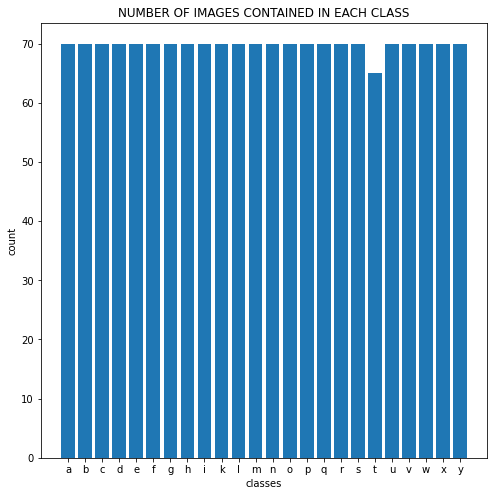

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,8))
plt.bar(labels, num)
plt.title('NUMBER OF IMAGES CONTAINED IN EACH CLASS')
plt.xlabel('classes')
plt.ylabel('count')
plt.show()

In [4]:
import cv2
import os

path = 'dataset/{0}/'

data2 = \
[(cv2.resize(cv2.imread(path.format(label)+img_path), (64, 64)), label) \
 for label in labels \
 for img_path in os.listdir(path.format(label))]

X_raw, y = zip(*data2)

X_raw, y = zip(*data2)
X_raw, y = list(X_raw), list(y)

In [5]:
X_raw = np.array(X_raw)
X_raw.shape

(1675, 64, 64, 3)

In [6]:
X_raw, y = np.array(X_raw), np.array(y)
print('the shape of X is: ', X_raw.shape, 'and that of Y is: ', y.shape)

the shape of X is:  (1675, 64, 64, 3) and that of Y is:  (1675,)


In [7]:
X = X_raw.astype(np.float32)/255

In [8]:
#converting the y_data into categorical:
from sklearn.preprocessing import LabelEncoder
y = LabelEncoder().fit_transform(y)

In [9]:
y

array([ 0,  0,  0, ..., 23, 23, 23], dtype=int64)

In [10]:
from keras.utils import to_categorical
y_categorical = to_categorical(y)

In [11]:
y_categorical

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, 
                                                    test_size = 0.3, 
                                                    shuffle=True)

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization

# use pretrained VGG 19 

In [14]:
from keras.models import Model
from keras.applications.vgg19 import VGG19

img_height = 64
img_width = 64
img_channels = 3

base = VGG19(include_top = False, weights='imagenet', input_shape = (img_height, img_width, img_channels))

def build_model():
    X = base.output
    X = Flatten()(X)
    X = Dense(512, activation = 'relu')(X)
    X = Dropout(0.4)(X)
    X = BatchNormalization()(X)
    X = Dense(512, activation = 'relu')(X)
    X = Dropout(0.3)(X)
    X = BatchNormalization()(X)
    preds = Dense(24, activation = 'softmax')(X)
    
    model = Model(inputs = base.input, outputs = preds)
    
    for layer in base.layers: layer.trainable = False
    
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model


In [15]:
model_vgg = build_model()
model_vgg.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)      

In [16]:
history_vgg = model_vgg.fit(X_train, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
30/30 [==============================] - 13s 449ms/step - loss: 2.0541 - accuracy: 0.4034 - val_loss: 1.6441 - val_accuracy: 0.7021
Epoch 2/5
30/30 [==============================] - 14s 456ms/step - loss: 0.8776 - accuracy: 0.7086 - val_loss: 1.0014 - val_accuracy: 0.8043
Epoch 3/5
30/30 [==============================] - 14s 456ms/step - loss: 0.6079 - accuracy: 0.8047 - val_loss: 0.6634 - val_accuracy: 0.9277
Epoch 4/5
30/30 [==============================] - 15s 485ms/step - loss: 0.5394 - accuracy: 0.8207 - val_loss: 0.5707 - val_accuracy: 0.9149
Epoch 5/5
30/30 [==============================] - 17s 555ms/step - loss: 0.4861 - accuracy: 0.8346 - val_loss: 0.6422 - val_accuracy: 0.9106


In [17]:
# Saving the model
model_vgg.save('my_model_vgg.h5')

#print(classifier.history.keys())

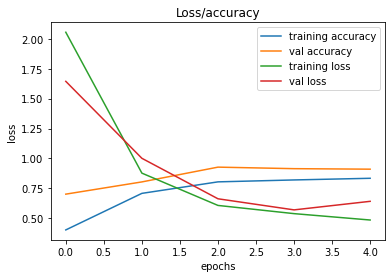

In [18]:
#Display of the accuracy and the loss values
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history_vgg.history['accuracy'], label='training accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='val accuracy')
plt.plot(history_vgg.history['loss'], label='training loss')
plt.plot(history_vgg.history['val_loss'], label='val loss')
plt.title('Loss/accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [19]:
y_pred_vgg = np.argmax(model_vgg.predict(X_test), axis=1)

In [20]:
y_test_ = np.argmax(y_test, axis = 1)

In [21]:
from sklearn.metrics import accuracy_score
print('the accuracy obtained on the test set is:', accuracy_score(y_test_, y_pred_vgg))

the accuracy obtained on the test set is: 0.8687872763419483


In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test_, y_pred_vgg))

              precision    recall  f1-score   support

           0       0.89      0.77      0.83        22
           1       1.00      1.00      1.00        24
           2       0.96      1.00      0.98        27
           3       1.00      0.37      0.54        19
           4       1.00      1.00      1.00        24
           5       1.00      0.81      0.89        21
           6       0.84      1.00      0.91        21
           7       1.00      0.85      0.92        20
           8       1.00      0.65      0.79        23
           9       0.69      1.00      0.82        25
          10       1.00      1.00      1.00        19
          11       0.87      0.87      0.87        15
          12       0.59      0.94      0.72        18
          13       0.77      1.00      0.87        17
          14       1.00      0.96      0.98        26
          15       1.00      1.00      1.00        18
          16       0.82      1.00      0.90        27
          17       0.81    

In [24]:
from dmba import classificationSummary
classificationSummary(y_test_, y_pred_vgg)

Confusion Matrix (Accuracy 0.8688)

       Prediction
Actual  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
     0 17  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  1  0  0  0  0  0  2
     1  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     2  0  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     3  0  0  0  7  0  0  0  0  0  6  0  0  0  0  0  0  2  0  0  0  4  0  0  0
     4  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     5  0  0  0  0  0 17  0  0  0  0  0  0  1  0  0  0  1  0  0  2  0  0  0  0
     6  0  0  0  0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     7  0  0  0  0  0  0  3 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     8  0  0  0  0  0  0  0  0 15  0  0  0  0  2  0  0  0  0  0  0  0  0  0  6
     9  0  0  0  0  0  0  0  0  0 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    10  0  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  

# Build my own model

In [25]:
model = Sequential()

# Step 1 - Convolution Layer
model.add(Conv2D(filters=32, kernel_size=3, padding="same", activation='relu', input_shape=(64, 64, 3)))

# step 2 - Pooling
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))

# Adding second convolution layer
model.add(Conv2D(filters=32, kernel_size=3, padding="same", activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))

# Adding 3rd Convolution Layer
model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))

# Step 3 - Flattening
model.add(Flatten())

# Step 4 - Full Connection
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(24, activation='softmax'))
               
# Compiling The CNN
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 64)        0

In [26]:
X_train.shape

(1172, 64, 64, 3)

In [27]:
#fitting the model
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
30/30 [==============================] - 3s 104ms/step - loss: 2.5780 - accuracy: 0.2199 - val_loss: 2.0705 - val_accuracy: 0.6936
Epoch 2/10
30/30 [==============================] - 3s 109ms/step - loss: 1.0823 - accuracy: 0.6457 - val_loss: 1.0430 - val_accuracy: 0.8766
Epoch 3/10
30/30 [==============================] - 3s 105ms/step - loss: 0.6131 - accuracy: 0.7866 - val_loss: 0.7503 - val_accuracy: 0.9064
Epoch 4/10
30/30 [==============================] - 3s 114ms/step - loss: 0.3880 - accuracy: 0.8666 - val_loss: 0.4300 - val_accuracy: 0.9532
Epoch 5/10
30/30 [==============================] - 3s 100ms/step - loss: 0.3025 - accuracy: 0.9018 - val_loss: 0.3877 - val_accuracy: 0.9489
Epoch 6/10
30/30 [==============================] - 3s 98ms/step - loss: 0.2892 - accuracy: 0.8954 - val_loss: 0.3834 - val_accuracy: 0.9617
Epoch 7/10
30/30 [==============================] - 3s 111ms/step - loss: 0.1923 - accuracy: 0.9296 - val_loss: 0.2439 - val_accuracy: 0.9574
Epoch 8

In [28]:
# Saving the model
model.save('my_model.h5')

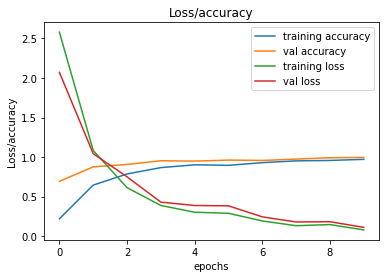

In [29]:
plt.figure()
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss/accuracy')
plt.xlabel('epochs')
plt.ylabel('Loss/accuracy')
plt.legend()
plt.show()

In [30]:
y_pred = np.argmax(model.predict(X_test), axis=1)

In [31]:
from sklearn.metrics import accuracy_score
print('the accuracy obtained on the test set is:', accuracy_score(y_test_, y_pred))

the accuracy obtained on the test set is: 0.9681908548707754


In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_test_, y_pred))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90        22
           1       1.00      1.00      1.00        24
           2       1.00      1.00      1.00        27
           3       0.86      1.00      0.93        19
           4       1.00      1.00      1.00        24
           5       1.00      1.00      1.00        21
           6       1.00      1.00      1.00        21
           7       1.00      1.00      1.00        20
           8       0.96      1.00      0.98        23
           9       1.00      0.84      0.91        25
          10       1.00      1.00      1.00        19
          11       1.00      1.00      1.00        15
          12       1.00      1.00      1.00        18
          13       1.00      1.00      1.00        17
          14       1.00      1.00      1.00        26
          15       1.00      1.00      1.00        18
          16       1.00      0.78      0.88        27
          17       1.00    

In [33]:
from dmba import classificationSummary
classificationSummary(y_test_, y_pred)

Confusion Matrix (Accuracy 0.9682)

       Prediction
Actual  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
     0 22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     1  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     2  0  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     3  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     4  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     5  0  0  0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     6  0  0  0  0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     7  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     8  0  0  0  0  0  0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     9  0  0  0  0  0  0  0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  4  0  0
    10  0  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  